#### 1. Read the training data for the Titanic from the subfolder `/data` into a DataFrame
> Remark: A description of the data may be found on [Kaggle](https://www.kaggle.com/c/titanic/data)

In [1]:
import pandas as pd
df_titanic = pd.read_csv("data/titanic_train.csv")
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### 2. Only keep the relevant attributes as well as rows without missing values
> Hints:<br>
> a. To obtain a copy of the relevant columns use `df_a = df.loc[:,['r1','r2',...,'rn']]`<br>
> b. The columns `Name`, `Ticket` and `Cabin` are irrelevant (for us ...)<br>
> c. DataFrames conveniently offer the method `dropna`

In [2]:
df_t = df_titanic.loc[:,['PassengerId','Survived','Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]
df_t = df_t.dropna()
df_t.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


#### 3. Recode the two categorial columns
> Hints: </br>
> * To overwrite the values of a column in a Dataframe also use `df.loc[:,['sp']] = ...`
> * For recoding, `sklearn` offers the `LabelEncoder` in its `preprocessing` module

In [3]:
import sklearn.preprocessing as pp
le = pp.LabelEncoder()

le.fit(df_t.loc[:,'Sex'])
list(le.classes_)
df_t.loc[:,'Sex'] = le.transform(df_t.loc[:,'Sex'])

le.fit(df_t.loc[:,'Embarked'])
list(le.classes_)
df_t.loc[:,'Embarked'] = le.transform(df_t.loc[:,'Embarked'])

df_t

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,1,22.0,1,0,7.2500,2
1,2,1,1,0,38.0,1,0,71.2833,0
2,3,1,3,0,26.0,0,0,7.9250,2
3,4,1,1,0,35.0,1,0,53.1000,2
4,5,0,3,1,35.0,0,0,8.0500,2
...,...,...,...,...,...,...,...,...,...
885,886,0,3,0,39.0,0,5,29.1250,1
886,887,0,2,1,27.0,0,0,13.0000,2
887,888,1,1,0,19.0,0,0,30.0000,2
889,890,1,1,1,26.0,0,0,30.0000,0


#### 4. Predict whether a person survived by training a decision tree of depth 3 using Gini impurity
> Hint: The vector $y$ of *binary class labels* is obviously given by the column `Survived`, while the rest of the data frame contains the *feature matrix* $X$

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

y = df_t['Survived']
X = df_t.drop(['Survived', 'PassengerId'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size=0.3, random_state=0)

tree = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)

tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

#### 5. What is the accuracy of the prediction and which features do not contribute at all to the decisions made?
> Hint: It makes sense to have a look at the [documentation of `DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

In [15]:
from sklearn.metrics import accuracy_score
y_predict = tree.predict(X_test)
print("Accuracy: {0:.2f}%".format(accuracy_score(y_test, y_predict)))

Accuracy: 0.79%


In [16]:
#accuracy = tree.score(X, y)
#print("Accuracy: {0:.2f}%".format(accuracy*100))

In [17]:
contribution = (dict(zip(X_train.columns, tree.feature_importances_)))
for feature in contribution:
    print('{0} : {1:.2f}%'.format(feature , contribution [feature]*100))

Pclass : 23.98%
Sex : 55.76%
Age : 6.11%
SibSp : 8.31%
Parch : 0.00%
Fare : 5.84%
Embarked : 0.00%


Parch and Embarked do not contribute, PassengerID was dropped beforehand since it is just an ID.

#### 6. Visualize the resulting tree

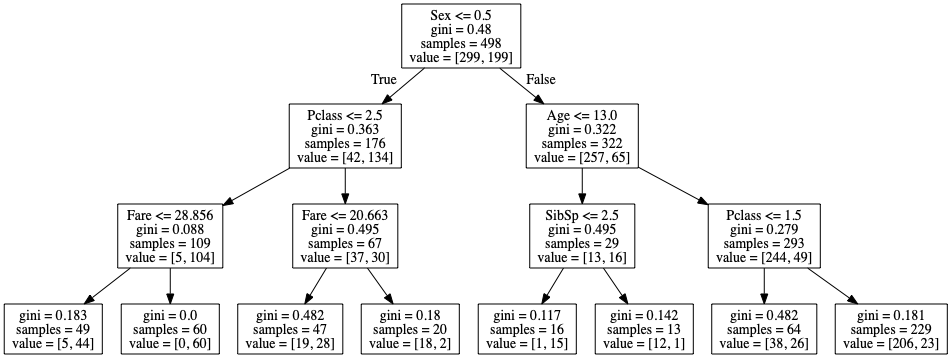

In [8]:
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = export_graphviz(tree, out_file=None, 
                                feature_names=X_train.columns,  
                          )#class_names=X.target_names)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

#### 7. Interpret the result (at least in part). Which persons had the best chance of survival?

Women in the first and second class as well as children (13 years of age and younger) had the best chance of survival.